In [1]:
%load_ext autoreload
%autoreload 2
print('\n')
print('=============loading external modules now=========')
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
print(f'tensorflow version: {tf.__version__}')
from tensorflow.keras import layers
import os, glob, math, random, time, datetime, PIL, imageio
from collections import defaultdict
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from IPython import display
import xml.etree.ElementTree as ET 
print('\n')
print('=============loading user-defined modules now=========')
print('\n')
start_=time.time()
start=time.time()
from optimizers import *
print(f'\t\toptimizers took {time.time()-start} s in loading')
print('======================')
print('\n')
start=time.time()
from losses import *
print(f'\t\tlosses took {time.time()-start} s in loading')
print('======================')
print('\n')
start=time.time()
from g_model import *
print(f'\t\tgenerator model took {time.time()-start} s in loading')
print('======================')
print('\n')
start=time.time()
from d_model import *
print(f'\t\tdiscriminator model took {time.time()-start} s in loading')
print('======================')
print('\n')
start=time.time()
from static import *
print(f'\t\tstatic took {time.time()-start} s in loading')
print('======================')
print('\n')
start=time.time()
from onboarding import *
print(f'\t\tonboarding took {time.time()-start} s in loading')
print('======================')
print(f'\tall user-defined modules took {time.time()-start_} s in loading')



=============loading external modules now=========
tensorflow version: 2.3.0


=============loading user-defined modules now=========


		optimizers took 0.0009572505950927734 s in loading


		losses took 0.00022220611572265625 s in loading


		generator model took 0.9339892864227295 s in loading


		discriminator model took 0.0006501674652099609 s in loading


		static took 5.4836273193359375e-05 s in loading


		onboarding took 0.0006403923034667969 s in loading
	all user-defined modules took 0.9376919269561768 s in loading


In [7]:
images_inputs, normalized_image_vectors, breeds_names = onboarding(all_images, all_breeds)

25it [00:00, 1128.61it/s]


CPU times: user 422 ms, sys: 0 ns, total: 422 ms
Wall time: 420 ms


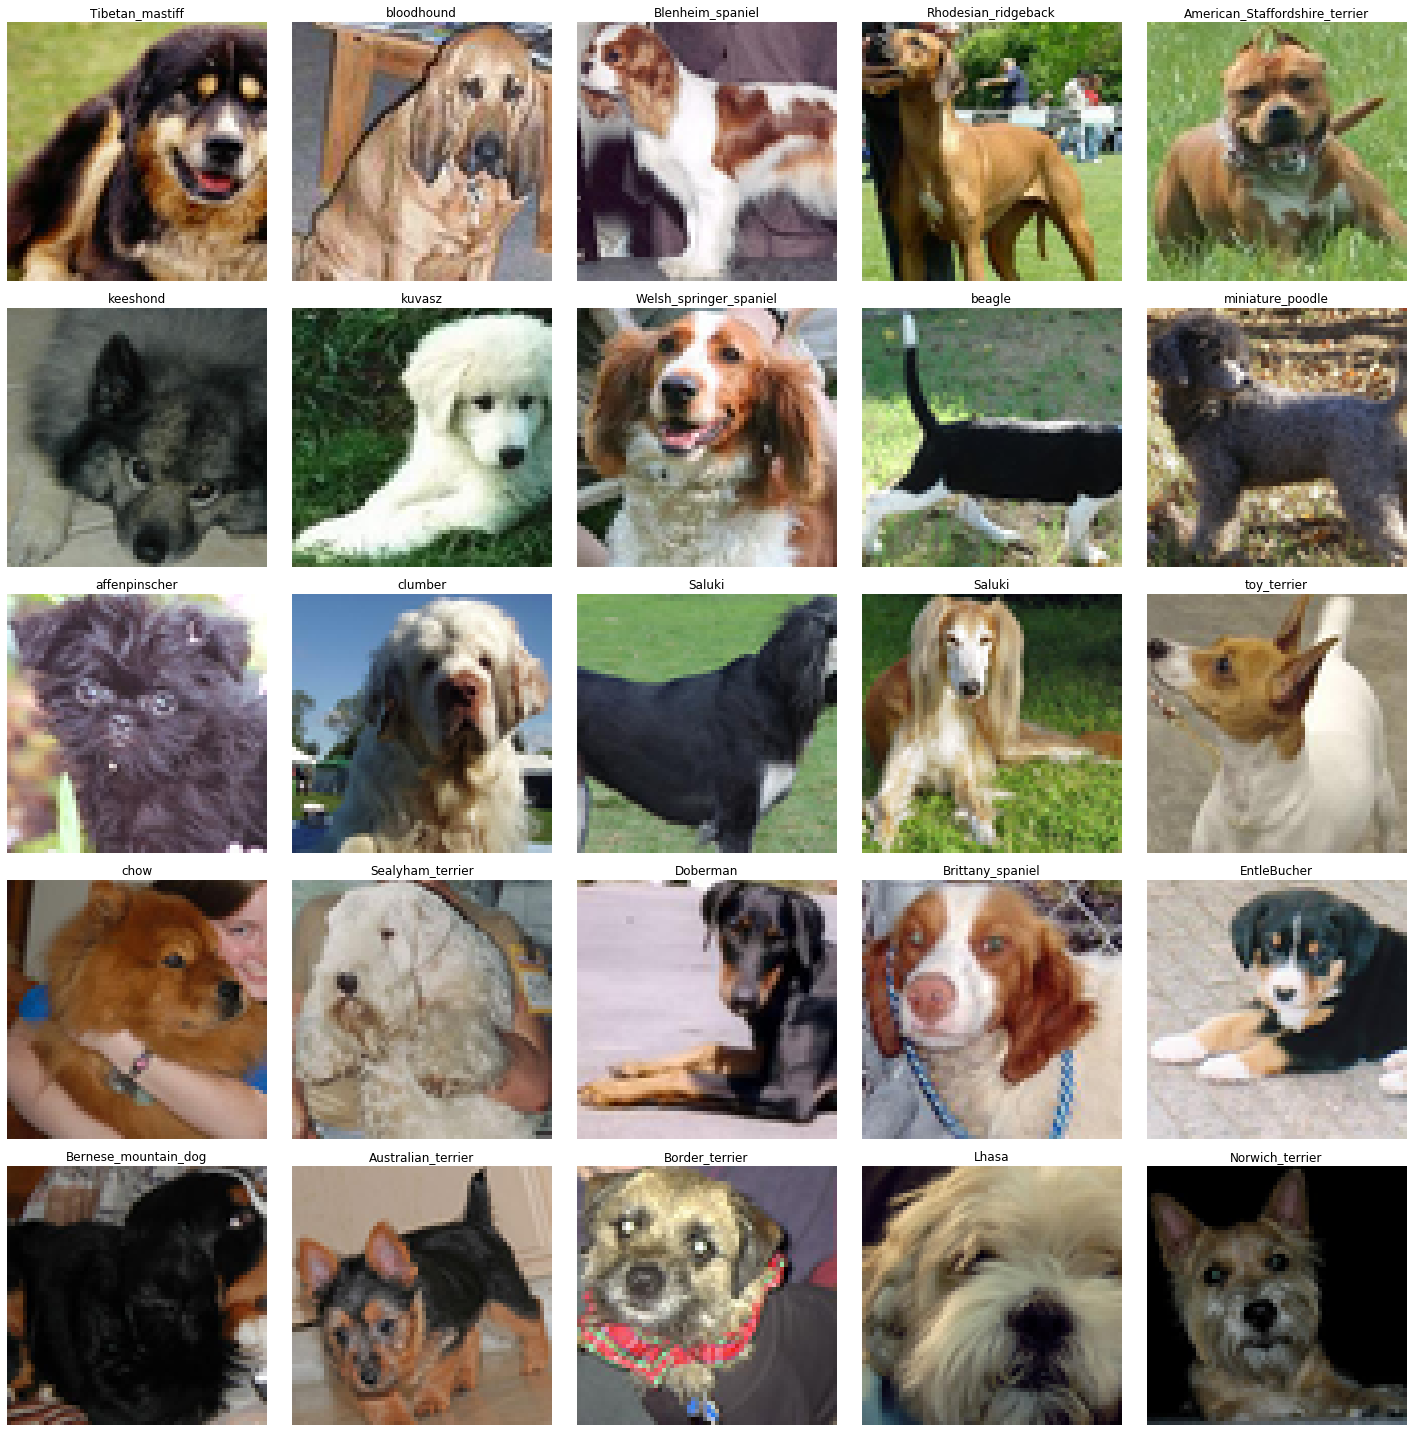

In [13]:
%%time
fig, axs = plt.subplots(5, 5, figsize=(20, 20))
for ax, id in tqdm(zip(axs.flatten(), rand_idx_viz)):
    ax.axis('off')
    ax.set_title(breeds_names[id].split('-')[1])
    img = Image.fromarray(images_inputs[id,:,:,:].astype('uint8'))
    ax.imshow(img)
    
plt.tight_layout()
# plt.savefig('../figures/dogs.png')

# Generative Network

The purpose of a generative network is to use a deconvolution network and generate a random image from a random vector.
Reference: https://arxiv.org/pdf/1505.04366.pdf

(None, 8, 8, 512)
(None, 16, 16, 256)
(None, 32, 32, 128)
(None, 64, 64, 64)
(None, 64, 64, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>
CPU times: user 1.11 s, sys: 185 ms, total: 1.3 s
Wall time: 1.41 s


(1, 64, 64, 3)

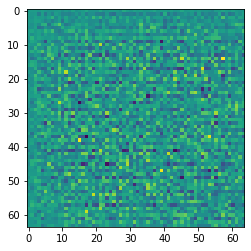

In [14]:
%%time
generator = g_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

print(type(generated_image))
plt.imshow((generated_image[0, :, :, 0]))
generator.predict(noise, steps=10).shape
# print(noise)

In [24]:
discriminator = d_model()
decision = discriminator(generated_image)
print(decision)

(None, 32, 32, 64)
(None, 16, 16, 128)
(None, 8, 8, 256)
(None, 1)
tf.Tensor([[0.5231351]], shape=(1, 1), dtype=float32)


In [25]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [26]:
checkpoint_dir = './training_checkpoints_1'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [187]:
imagesIn = tf.cast(imagesIn, 'float32')

In [188]:
BUFFER_SIZE = 20000
BATCH_SIZE = 32
ds = tf.data.Dataset.from_tensor_slices(imagesIn).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(ds)

<BatchDataset shapes: (None, 64, 64, 3), types: tf.float32>


In [194]:
discriminator_optimizer

In [195]:
from loss import *

In [198]:
generator_loss

<function loss.generator_loss(fake_output)>

# Training Loop

In [11]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

NameError: name 'generator' is not defined

In [8]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
          generated_images = generator(noise, training=True)

          real_output = discriminator(images, training=True)
          fake_output = discriminator(generated_images, training=True)

          gen_loss = generator_loss(fake_output)
          disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [9]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,\
                           epochs,\
                           seed)


In [232]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(8,8))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')

  plt.savefig('../training_result/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

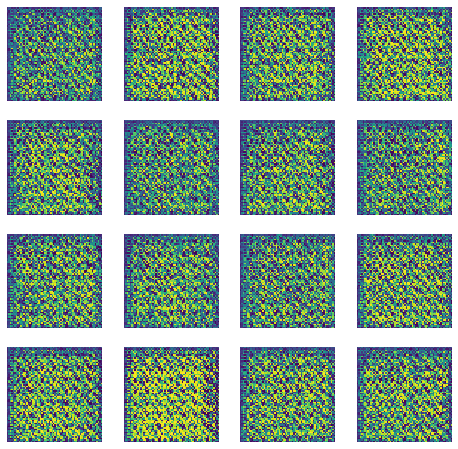

CPU times: user 39min 8s, sys: 8min 40s, total: 47min 49s
Wall time: 3h 47min 43s


In [251]:
%%time
print('Starting training')
train_dataset=ds
EPOCHS = 300
train(train_dataset, EPOCHS)

In [248]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard


In [243]:
tf.constant([6])

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([6], dtype=int32)>

In [10]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

NameError: name 'checkpoint' is not defined

In [263]:
!ls training_checkpoints

checkpoint		     ckpt-19.index
ckpt-1.data-00000-of-00001   ckpt-2.data-00000-of-00001
ckpt-1.index		     ckpt-2.index
ckpt-10.data-00000-of-00001  ckpt-20.data-00000-of-00001
ckpt-10.index		     ckpt-20.index
ckpt-11.data-00000-of-00001  ckpt-21.data-00000-of-00001
ckpt-11.index		     ckpt-21.index
ckpt-12.data-00000-of-00001  ckpt-3.data-00000-of-00001
ckpt-12.index		     ckpt-3.index
ckpt-13.data-00000-of-00001  ckpt-4.data-00000-of-00001
ckpt-13.index		     ckpt-4.index
ckpt-14.data-00000-of-00001  ckpt-5.data-00000-of-00001
ckpt-14.index		     ckpt-5.index
ckpt-15.data-00000-of-00001  ckpt-6.data-00000-of-00001
ckpt-15.index		     ckpt-6.index
ckpt-16.data-00000-of-00001  ckpt-7.data-00000-of-00001
ckpt-16.index		     ckpt-7.index
ckpt-17.data-00000-of-00001  ckpt-8.data-00000-of-00001
ckpt-17.index		     ckpt-8.index
ckpt-18.data-00000-of-00001  ckpt-9.data-00000-of-00001
ckpt-18.index		     ckpt-9.index
ckpt-19.data-00000-of-00001


In [255]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [259]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

AttributeError: module 'google.protobuf.descriptor' has no attribute '_internal_create_key'

In [257]:
pip show protobuf

Name: protobuf
Version: 3.13.0
Summary: Protocol Buffers
Home-page: https://developers.google.com/protocol-buffers/
Author: None
Author-email: None
License: 3-Clause BSD License
Location: /home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages
Requires: six, setuptools
Required-by: tensorflow-serving-api, tensorflow-docs, sagemaker, protobuf3-to-dict, tensorflow-gpu, tensorboard
Note: you may need to restart the kernel to use updated packages.


In [258]:
pip install --upgrade protobuf

Requirement already up-to-date: protobuf in /home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages (3.13.0)
Note: you may need to restart the kernel to use updated packages.


In [260]:
anim_file

'dcgan.gif'